In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing, cross_validation, metrics #model_selection, 
#from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import Imputer

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()


pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

#id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

def RMSE_(y_val, y_val_pred):
    return np.sqrt(np.mean((y_val-y_val_pred)**2))
RMSE = make_scorer(RMSE_, greater_is_better=False)

from time import time

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
X_train = pd.read_csv('./input/train_further_additional_feature_filtered.csv',index_col=0)
y_train = pd.read_csv('./input/y_train_further_additional_feature_filtered.csv',index_col=0)['price_doc']
X_test = pd.read_csv('./input/test_further_additional_feature_filtered.csv',index_col=0)
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])
id_test = pd.read_csv('./input/test.csv').id

In [3]:
imp = Imputer(missing_values=np.nan, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [4]:
imp = Imputer(missing_values=np.infty, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [5]:
target = "price_doc"
predictors = X_train.columns
X_train[target]=y_train

In [11]:
def modelfitGBM(alg, dtrain, predictors, target=target, CVMetrics=RMSLE, outputMetrics=RMSLE_,
                performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], 
                                                    dtrain[ target], cv=cv_folds, scoring=CVMetrics)
    
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "RMSE (Train): %f" % outputMetrics(dtrain[target], dtrain_predictions)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)[:50]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.figure(figsize=(20,10))

In [ ]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfitGBM(gbm0, X_train, predictors, target)

In [7]:
param_test = {'n_estimators':range(20,81,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1, cv=5)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.48291, std: 0.04669, params: {'n_estimators': 20},
  mean: -0.47337, std: 0.04676, params: {'n_estimators': 30},
  mean: -0.46949, std: 0.04748, params: {'n_estimators': 40},
  mean: -0.46715, std: 0.04741, params: {'n_estimators': 50},
  mean: -0.46560, std: 0.04717, params: {'n_estimators': 60},
  mean: -0.46438, std: 0.04682, params: {'n_estimators': 70},
  mean: -0.46341, std: 0.04648, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 -0.4634088766916293)

In [14]:
param_test = {'n_estimators':range(100,1100,100)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1, cv=5)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.47097, std: 0.04616, params: {'n_estimators': 100},
  mean: -0.46483, std: 0.04621, params: {'n_estimators': 200},
  mean: -0.46254, std: 0.04574, params: {'n_estimators': 300},
  mean: -0.46188, std: 0.04584, params: {'n_estimators': 400},
  mean: -0.46173, std: 0.04599, params: {'n_estimators': 500},
  mean: -0.46174, std: 0.04578, params: {'n_estimators': 600},
  mean: -0.46169, std: 0.04554, params: {'n_estimators': 700},
  mean: -0.46167, std: 0.04566, params: {'n_estimators': 800},
  mean: -0.46176, std: 0.04515, params: {'n_estimators': 900},
  mean: -0.46207, std: 0.04488, params: {'n_estimators': 1000}],
 {'n_estimators': 800},
 -0.46166784063712796)

In [7]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500,
                        min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -2687767.66795, std: 159144.47282, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: -2689357.94551, std: 156801.83718, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: -2703497.84767, std: 159537.96242, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: -2710556.42870, std: 163910.13816, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: -2712975.07565, std: 139220.10524, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: -2670805.50105, std: 157964.62066, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: -2679970.03701, std: 144848.92631, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: -2708982.99551, std: 153812.20833, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: -2712652.65955, std: 142190.75455, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: -2711397.19987, std: 153329.68957, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: -2693009.94786, std: 153373.33940, param

In [7]:
param_test = {'max_depth':range(6,9,1), 'min_samples_leaf':range(30,71,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500,
                        min_samples_split=200,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.46086, std: 0.06727, params: {'max_depth': 6, 'min_samples_leaf': 30},
  mean: -0.46021, std: 0.06641, params: {'max_depth': 6, 'min_samples_leaf': 40},
  mean: -0.46030, std: 0.06694, params: {'max_depth': 6, 'min_samples_leaf': 50},
  mean: -0.46117, std: 0.06727, params: {'max_depth': 6, 'min_samples_leaf': 60},
  mean: -0.45964, std: 0.06737, params: {'max_depth': 6, 'min_samples_leaf': 70},
  mean: -0.46321, std: 0.06751, params: {'max_depth': 7, 'min_samples_leaf': 30},
  mean: -0.46293, std: 0.06696, params: {'max_depth': 7, 'min_samples_leaf': 40},
  mean: -0.46303, std: 0.06697, params: {'max_depth': 7, 'min_samples_leaf': 50},
  mean: -0.46342, std: 0.06626, params: {'max_depth': 7, 'min_samples_leaf': 60},
  mean: -0.46331, std: 0.06754, params: {'max_depth': 7, 'min_samples_leaf': 70},
  mean: -0.46645, std: 0.06727, params: {'max_depth': 8, 'min_samples_leaf': 30},
  mean: -0.46541, std: 0.06729, params: {'max_depth': 8, 'min_samples_leaf': 40},
  mean: -0.46558

In [8]:
param_test = {'min_samples_leaf':range(70,100,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500,
                        min_samples_split=200,max_features='sqrt',max_depth=6,subsample=0.8,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.45964, std: 0.06737, params: {'min_samples_leaf': 70},
  mean: -0.46045, std: 0.06616, params: {'min_samples_leaf': 80},
  mean: -0.46010, std: 0.06621, params: {'min_samples_leaf': 90}],
 {'min_samples_leaf': 70},
 -0.459640082751645)


Model Report
RMSE (Train): 0.418750
CV Score : Mean - -0.4726126 | Std - 0.05417188 | Min - -0.5744144 | Max - -0.4231801


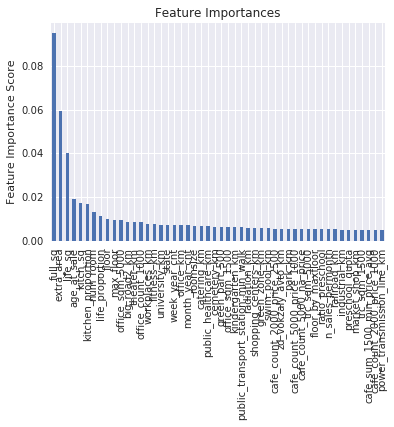

In [12]:
modelfitGBM(gsearch.best_estimator_, X_train, predictors, target, CVMetrics=RMSLE, outputMetrics=RMSLE_)

In [13]:
param_test = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500,min_samples_leaf=70,
                        min_samples_split=200,max_features='sqrt',max_depth=6,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.46219, std: 0.06565, params: {'subsample': 0.6},
  mean: -0.46095, std: 0.06612, params: {'subsample': 0.7},
  mean: -0.45991, std: 0.06675, params: {'subsample': 0.75},
  mean: -0.45964, std: 0.06737, params: {'subsample': 0.8},
  mean: -0.45954, std: 0.06685, params: {'subsample': 0.85},
  mean: -0.46017, std: 0.06644, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 -0.459540464029466)

In [17]:
param_test = {'max_features':1/10.0*np.arange(1,10,1)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500,min_samples_leaf=70,
                        min_samples_split=200,subsample=0.85,max_depth=6,random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.46044, std: 0.06619, params: {'max_features': 0.10000000000000001},
  mean: -0.46180, std: 0.06693, params: {'max_features': 0.20000000000000001},
  mean: -0.46140, std: 0.06841, params: {'max_features': 0.30000000000000004},
  mean: -0.46152, std: 0.06687, params: {'max_features': 0.40000000000000002},
  mean: -0.46100, std: 0.06765, params: {'max_features': 0.5},
  mean: -0.46181, std: 0.06795, params: {'max_features': 0.60000000000000009},
  mean: -0.46258, std: 0.06724, params: {'max_features': 0.70000000000000007},
  mean: -0.46248, std: 0.06762, params: {'max_features': 0.80000000000000004},
  mean: -0.46296, std: 0.06718, params: {'max_features': 0.90000000000000002}],
 {'max_features': 0.10000000000000001},
 -0.46043537017044384)


Model Report
RMSE (Train): 0.433362
CV Score : Mean - -0.4690654 | Std - 0.05529208 | Min - -0.5730051 | Max - -0.4184762


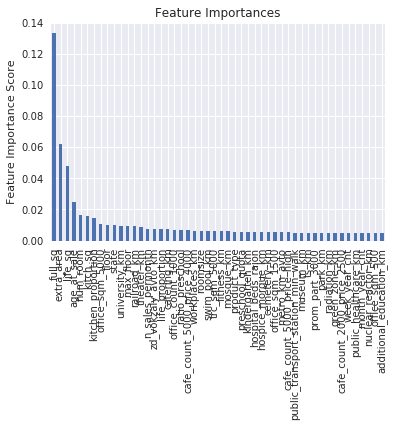

In [21]:
GBMreg=GradientBoostingRegressor(learning_rate=0.05, n_estimators=500,min_samples_leaf=70,
                        min_samples_split=200, max_features=.1,max_depth=6,subsample=0.85,random_state=10)
modelfitGBM(GBMreg, X_train, predictors, target, CVMetrics=RMSLE, outputMetrics=RMSLE_)

In [13]:
GBMreg=GradientBoostingRegressor(learning_rate=0.05, n_estimators=500,min_samples_leaf=70,
                        min_samples_split=200, max_features=.1,max_depth=6,subsample=0.85,random_state=10)
GBMreg.fit(X_train, np.log(y_train+1))
y_predict = rfreg.predict(X_test)
y_predict = np.exp(y_predict)-1
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
#output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [14]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.to_csv('Jun17_1_GBMTuning_eta_nEst500_minSampSplt_maxFeat_maxDpt_subSample_rndSt10.csv', index=False)